## Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
#import soccerdata as sd
import re
from unidecode import unidecode
from scipy.spatial import ConvexHull
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import ax_text, fig_text


from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import main
import visuals
import seaborn as sns
import requests
import utils
import os
%load_ext autoreload
%autoreload 2

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#010b14"
text_color = 'black'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

In [2]:
import matplotlib.font_manager as fm
from mplsoccer import FontManager

# Set the path to the locally downloaded font file
font_path = r'C:\Users\acer\Documents\GitHub\IndianCitizen\ScorePredict\Score Logos-20241022T100701Z-001\Score Logos\Sora_Font\Sora-Regular.ttf'

# Add the font to matplotlib
font_prop = fm.FontProperties(fname=font_path)

# You can now use this font in your plots
fm_sora = FontManager()
#fm_sora.prop = font_prop

print("Font loaded and registered successfully!")

Font loaded and registered successfully!


## Reading Data

In [3]:
df = pd.read_csv("D:/Scrape-Whoscored-Event-Data/data/bundesliga_1.csv")

In [7]:
list(df.columns)

['Unnamed: 0',
 'id',
 'eventId',
 'minute',
 'second',
 'teamId',
 'h_a',
 'x',
 'y',
 'expandedMinute',
 'period',
 'type',
 'outcomeType',
 'qualifiers',
 'satisfiedEventsTypes',
 'isTouch',
 'matchId',
 'startDate',
 'startTime',
 'score',
 'ftScore',
 'htScore',
 'etScore',
 'venueName',
 'maxMinute',
 'playerId',
 'playerName',
 'endX',
 'endY',
 'relatedEventId',
 'relatedPlayerId',
 'goalMouthZ',
 'goalMouthY',
 'isShot',
 'blockedX',
 'blockedY',
 'isGoal',
 'cardType',
 'shotBodyType',
 'situation',
 'shotSixYardBox',
 'shotPenaltyArea',
 'shotOboxTotal',
 'shotOpenPlay',
 'shotCounter',
 'shotSetPiece',
 'shotDirectCorner',
 'shotOffTarget',
 'shotOnPost',
 'shotOnTarget',
 'shotsTotal',
 'shotBlocked',
 'shotRightFoot',
 'shotLeftFoot',
 'shotHead',
 'shotObp',
 'goalSixYardBox',
 'goalPenaltyArea',
 'goalObox',
 'goalOpenPlay',
 'goalCounter',
 'goalSetPiece',
 'penaltyScored',
 'goalOwn',
 'goalNormal',
 'goalRightFoot',
 'goalLeftFoot',
 'goalHead',
 'goalObp',
 'shortPa

In [4]:
df['matchId'].nunique()

10

Dashboard - Top Performers of the Week - 3x3 grid - 
Most Shots,Passes,Touches,Tackles, Top 5 xT Created , Top 5 Shot Sequence Involvement , Most Passes Received , Most Dribbles , Top 5 Goalkeepers Based on Saves

In [448]:
teams_dict = {
    13: 'Arsenal',
    161: 'Wolves',
    24: 'Aston Villa',
    211: 'Brighton',
    30: 'Tottenham',
    167: 'Man City',
    14: 'Leicester',
    18: 'Southampton',
    183: 'Bournemouth',
    26: 'Liverpool',
    23: 'Newcastle',
    15: 'Chelsea',
    174: 'Nottingham Forest',
    29: 'West Ham',
    32: 'Man Utd',
    170: 'Fulham',
    189: 'Brentford',
    162: 'Crystal Palace',
    31: 'Everton',
    165: 'Ipswich'
}

In [5]:
teams_dict = {
    37: 'Bayern Munich',
    36: 'Bayer Leverkusen',
    45: 'Eintracht Frankfurt',
    219: 'Mainz 05',
    50: 'Freiburg',
    7614: 'RB Leipzig',
    33: 'Wolfsburg',
    134: 'Borussia M.Gladbach',
    41: 'VfB Stuttgart',
    44: 'Borussia Dortmund',
    1730: 'Augsburg',
    42: 'Werder Bremen',
    1211: 'Hoffenheim',
    796: 'Union Berlin',
    283: 'St. Pauli',
    1206: 'Holstein Kiel',
    162: 'FC Heidenheim',
    109: 'Bochum'
}

In [6]:
# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})
# new column for cumulative minutes, This part is taken from the "jakeyk11.github.io" github repository and modified for my use
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()

    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2
                carry['playerName'] = nex['playerName']

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

In [450]:
print(list(df.columns))

['Unnamed: 0', 'id', 'eventId', 'minute', 'teamId', 'h_a', 'playerId', 'playerName', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'matchId', 'startDate', 'startTime', 'score', 'ftScore', 'htScore', 'etScore', 'venueName', 'maxMinute', 'second', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY', 'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal', 'shotBodyType', 'situation', 'shotSixYardBox', 'shotPenaltyArea', 'shotOboxTotal', 'shotOpenPlay', 'shotCounter', 'shotSetPiece', 'shotDirectCorner', 'shotOffTarget', 'shotOnPost', 'shotOnTarget', 'shotsTotal', 'shotBlocked', 'shotRightFoot', 'shotLeftFoot', 'shotHead', 'shotObp', 'goalSixYardBox', 'goalPenaltyArea', 'goalObox', 'goalOpenPlay', 'goalCounter', 'goalSetPiece', 'penaltyScored', 'goalOwn', 'goalNormal', 'goalRightFoot', 'goalLeftFoot', 'goalHead', 'goalObp', 'shortPassInaccurate', 'shortPassAccurate', 'passCorner', 'passCornerAccurate

In [7]:
df = df.sort_values(by='matchId')

In [8]:
# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
# xT = pd.read_csv("/content/xT_Grid.csv", header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot', 'relatedEventId', 'relatedPlayerId', 'isGoal', 'cardType', 'isOwnGoal', 'cumulative_mins', 'Unnamed: 0', 'id', 'h_a', 'matchId', 'startDate', 'startTime', 'score', 'ftScore', 'htScore', 'etScore', 'venueName', 'maxMinute', 'playerName', 'shotBodyType', 'situation', 'shotSixYardBox', 'shotPenaltyArea', 'shotOboxTotal', 'shotOpenPlay', 'shotCounter', 'shotSetPiece', 'shotDirectCorner', 'shotOffTarget', 'shotOnPost', 'shotOnTarget', 'shotsTotal', 'shotBlocked', 'shotRightFoot', 'shotLeftFoot', 'shotHead', 'shotObp', 'goalSixYardBox', 'goalPenaltyArea', 'goalObox', 'goalOpenPlay', 'goalCounter', 'goalSetPiece', 'penaltyScored', 'goalOwn', 'goalNormal', 'goalRightFoot', 'goalLeftFoot', 'goalHead', 'goalObp', 'shortPassInaccurate', 'shortPassAccurate', 'passCorner', 'passCornerAccurate', 'passCornerInaccurate', 'passFreekick', 'passBack', 'passForward', 'passLeft', 'passRight', 'keyPassLong', 'keyPassShort', 'keyPassCross', 'keyPassCorner', 'keyPassThroughball', 'keyPassFreekick', 'keyPassThrowin', 'keyPassOther', 'assistCross', 'assistCorner', 'assistThroughball', 'assistFreekick', 'assistThrowin', 'assistOther', 'dribbleLost', 'dribbleWon', 'challengeLost', 'interceptionWon', 'clearanceHead', 'outfielderBlock', 'passCrossBlockedDefensive', 'outfielderBlockedPass', 'offsideGiven', 'offsideProvoked', 'foulGiven', 'foulCommitted', 'yellowCard', 'voidYellowCard', 'secondYellow', 'redCard', 'turnover', 'dispossessed', 'saveLowLeft', 'saveHighLeft', 'saveLowCentre', 'saveHighCentre', 'saveLowRight', 'saveHighRight', 'saveHands', 'saveFeet', 'saveObp', 'saveSixYardBox', 'savePenaltyArea', 'saveObox', 'keeperDivingSave', 'standingSave', 'closeMissHigh', 'closeMissHighLeft', 'closeMissHighRight', 'closeMissLeft', 'closeMissRight', 'shotOffTargetInsideBox', 'touches', 'assist', 'ballRecovery', 'clearanceEffective', 'clearanceTotal', 'clearanceOffTheLine', 'dribbleLastman', 'errorLeadsToGoal', 'errorLeadsToShot', 'intentionalAssist', 'interceptionAll', 'interceptionIntheBox', 'keeperClaimHighLost', 'keeperClaimHighWon', 'keeperClaimLost', 'keeperClaimWon', 'keeperOneToOneWon', 'parriedDanger', 'parriedSafe', 'collected', 'keeperPenaltySaved', 'keeperSaveInTheBox', 'keeperSaveTotal', 'keeperSmother', 'keeperSweeperLost', 'keeperMissed', 'passAccurate', 'passBackZoneInaccurate', 'passForwardZoneAccurate', 'passInaccurate', 'passAccuracy', 'cornerAwarded', 'passKey', 'passChipped', 'passCrossAccurate', 'passCrossInaccurate', 'passLongBallAccurate', 'passLongBallInaccurate', 'passThroughBallAccurate', 'passThroughBallInaccurate', 'passThroughBallInacurate', 'passFreekickAccurate', 'passFreekickInaccurate', 'penaltyConceded', 'penaltyMissed', 'penaltyWon', 'passRightFoot', 'passLeftFoot', 'passHead', 'sixYardBlock', 'tackleLastMan', 'tackleLost', 'tackleWon', 'cleanSheetGK', 'cleanSheetDL', 'cleanSheetDC', 'cleanSheetDR', 'cleanSheetDML', 'cleanSheetDMC', 'cleanSheetDMR', 'cleanSheetML', 'cleanSheetMC', 'cleanSheetMR', 'cleanSheetAML', 'cleanSheetAMC', 'cleanSheetAMR', 'cleanSheetFWL', 'cleanSheetFW', 'cleanSheetFWR', 'cleanSheetSub', 'goalConcededByTeamGK', 'goalConcededByTeamDL', 'goalConcededByTeamDC', 'goalConcededByTeamDR', 'goalConcededByTeamDML', 'goalConcededByTeamDMC', 'goalConcededByTeamDMR', 'goalConcededByTeamML', 'goalConcededByTeamMC', 'goalConcededByTeamMR', 'goalConcededByTeamAML', 'goalConcededByTeamAMC', 'goalConcededByTeamAMR', 'goalConcededByTeamFWL', 'goalConcededByTeamFW', 'goalConcededByTeamFWR', 'goalConcededByTeamSub', 'goalConcededOutsideBoxGoalkeeper', 'goalScoredByTeamGK', 'goalScoredByTeamDL', 'goalScoredByTeamDC', 'goalScoredByTeamDR', 'goalScoredByTeamDML', 'goalScoredByTeamDMC', 'goalScoredByTeamDMR', 'goalScoredByTeamML', 'goalScoredByTeamMC', 'goalScoredByTeamMR', 'goalScoredByTeamAML', 'goalScoredByTeamAMC', 'goalScoredByTeamAMR', 'goalScoredByTeamFWL', 'goalScoredByTeamFW', 'goalScoredByTeamFWR', 'goalScoredByTeamSub', 'aerialSuccess', 'duelAerialWon', 'duelAerialLost', 'offensiveDuel', 'defensiveDuel', 'bigChanceMissed', 'bigChanceScored', 'bigChanceCreated', 'overrun', 'successfulFinalThirdPasses', 'punches', 'penaltyShootoutScored', 'penaltyShootoutMissedOffTarget', 'penaltyShootoutSaved', 'penaltyShootoutSavedGK', 'penaltyShootoutConcededGK', 'throwIn', 'subOn', 'subOff', 'defensiveThird', 'midThird', 'finalThird', 'pos', 'EPV']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

# New Column for Team Names and Oppositon TeamNames
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
#opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
#df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'),
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'),
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['playerName'] = df['playerName'].astype(str)
df['playerName'] = df['playerName'].apply(unidecode)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['playerName'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['id']
df.drop(columns=columns_to_drop2, inplace=True)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime',
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

C:\Users\acer\AppData\Local\Temp\ipykernel_12480\87808713.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_12480\87808713.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)


## Data Prep

In [9]:
df = df[df['matchId'] != 1834419]

In [10]:
# Count the number of unique matches each team has played
team_matches = df.groupby('teamId')['matchId'].nunique().reset_index()

# Display teams that have played more than one match
multiple_matches = team_matches[team_matches['matchId'] > 1]

print(multiple_matches)

Empty DataFrame
Columns: [teamId, matchId]
Index: []


### Player with the most Passes

In [11]:
# Filter only pass events
pass_df = df[df['type'] == 'Pass']

# Count passes per player
pass_counts = pass_df.groupby('playerName')['index'].count().reset_index()

# Get the player with the most passes
most_passes = pass_counts.loc[pass_counts['index'].idxmax()]

print(most_passes)

# Get the player with the most passes
top_passer_name = most_passes['playerName']

# Filter dataframe for passes made by that player
top_passer_df = df[(df['type'] == 'Pass') & (df['playerName'] == top_passer_name)]

passer_player_team = top_passer_df['teamName'].iloc[0]

# Get matchId of the player
matchId = df[df['teamName'] == passer_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = df[df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
passer_opposition_team = [team for team in teams_in_match if team != passer_player_team][0]

print(passer_opposition_team)

playerName    Emre Can
index              115
Name: 61, dtype: object
St. Pauli


In [248]:
def player_passMap2(ax,dfpass, pname,player_team,against,team_color):
    pitch = Pitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5,
                         positional=True, shade_middle=True, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']

    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0

    #pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
    #                    (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball'))]
    through_pass_acc = through_pass[through_pass['outcomeType']=='Successful']
    long_pass = dfpass[(dfpass['qualifiers'].str.contains('Longball'))]
    long_pass_acc = long_pass[long_pass['outcomeType']=='Successful']
    cross = dfpass[(dfpass['qualifiers'].str.contains('Cross'))]
    cross_acc = cross[cross['outcomeType']=='Successful']
    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') &
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['playerName']==pname)]
    #shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    assist = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) &
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    corners_acc = corners[corners['outcomeType']=='Successful']
    freekick = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    freekick_acc = freekick[freekick['outcomeType']=='Successful']
    throws = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    throws_acc = throws[throws['outcomeType']=='Successful']

    df_xT_inc = dfpass[dfpass['xT']>0]
    df_xT_dec = dfpass[dfpass['xT']<0]
    xT_by_Pass = dfpass['xT'].sum().round(2)

    #pitch.lines(iac_pass.y, iac_pass.x, iac_pass.endY, iac_pass.endX, color='grey', lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='grey', lw=1, alpha=0.5, comet=False, zorder=2, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='yellow',  lw=2, alpha=0.8,comet=False, zorder=5, ax=ax)
    pitch.lines(assist.x, assist.y, assist.endX, assist.endY, color='#fb694a', lw=4, alpha=1,comet=True, zorder=6, ax=ax)
    pitch.lines(pen_box.x, pen_box.y, pen_box.endX, pen_box.endY, color='yellow', lw=2, alpha=0.8,comet=False, zorder=4, ax=ax)
    pitch.lines(fnl_thd.x, fnl_thd.y, fnl_thd.endX, fnl_thd.endY, color=team_color, lw=2, alpha=0.5,comet=False, zorder=3, ax=ax)
    
    ax.scatter(acc_pass.endX, acc_pass.endY, s=50, color=background,edgecolor='white', alpha=0.5, zorder=2)
    ax.scatter(key_pass.endX, key_pass.endY, s=100, color=background,edgecolor='yellow', alpha=0.8, zorder=5)
    ax.scatter(assist.endX, assist.endY, s=100, color=background,edgecolor='#fb694a', alpha=1, zorder=6)
    ax.scatter(fnl_thd.endX, fnl_thd.endY, s=100, color=background,edgecolor=team_color, alpha=0.5, zorder=4)
    ax.scatter(pen_box.endX, pen_box.endY, s=100, color=background,edgecolor='#eaea72', alpha=0.8, zorder=3)
    
    ax.text(20,80,f"Most Passes - {pname}", color='white', fontsize=25,fontproperties=font_prop)
    ax.text(35,74,f"Against {against}", color='white', fontsize=20,fontproperties=font_prop)
    #<Passes into Penalty box: {len(pen_box)}> \n\n
    ax_text(-3, -11, f'''
    Passes: {len(acc_pass)}/{len(dfpass)} ({accurate_pass_perc}%)                                <Assists: {len(assist)}>\n
    <Final third Passes: {len(fnl_thd)}>                                    <Key Passes: {len(key_pass)}>
    ''',
    color='white',fontproperties=font_prop,transform=ax.transAxes,
    highlight_textprops=[{'color':'#fb694a'}, {'color':team_color},{'color':'yellow'}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)
    
    return

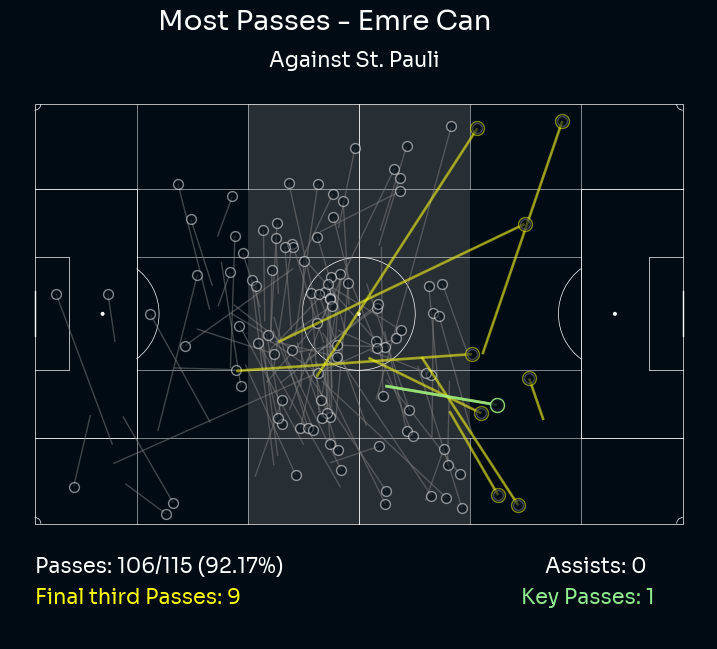

In [34]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
player_passMap2(ax,top_passer_df, top_passer_name,passer_player_team,passer_opposition_team,'white')

### Player with the most shots

In [185]:
df['type'].unique()

array(['Start', 'Pass', 'BallRecovery', 'MissedShots', 'BallTouch',
       'Interception', 'BlockedPass', 'Tackle', 'Dispossessed', 'Aerial',
       'TakeOn', 'Challenge', 'Clearance', 'CornerAwarded', 'Error',
       'SubstitutionOn', 'SubstitutionOff', 'Goal', 'KeeperPickup',
       'KeeperSweeper', 'Foul', 'Card', 'Save', 'SavedShot', 'Claim',
       'ShieldBallOpp', 'GoodSkill', 'FormationChange', 'OffsidePass',
       'OffsideProvoked', 'Punch', 'End', 'OffsideGiven', 'FormationSet',
       'Smother', 'ShotOnPost', 'PenaltyFaced', 'Carry'], dtype=object)

In [44]:
 # Filter only pass events
shots_df = df[(df['type'] == 'MissedShots') | (df['type'] == 'Goal') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')]

# Count passes per player
shot_counts = shots_df.groupby('playerName')['index'].count().reset_index()

# Get the player with the most passes
most_shots = shot_counts.loc[shot_counts['index'].idxmax()]

print(most_shots)

# Get the player with the most passes
top_shots_name = most_shots['playerName']

print(top_shots_name)

# Filter dataframe for passes made by that player
top_shots_df = df[((df['type'] == 'MissedShots') | (df['type'] == 'Goal') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')) & (df['playerName'] == top_shots_name)]

shots_player_team = top_shots_df['teamName'].iloc[0]

print(shots_player_team)

# Get matchId of the player
matchId = df[df['teamName'] == shots_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = df[df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
shots_opposition_team = [team for team in teams_in_match if team != shots_player_team][0]

print(shots_opposition_team)

playerName    Karim Adeyemi
index                     6
Name: 55, dtype: object
Karim Adeyemi
Borussia Dortmund
St. Pauli


In [205]:
def shotMap(ax,shots_df,pname,against,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)

    missed = shots_df[shots_df['type'] == 'MissedShots']
    saved = shots_df[shots_df['type'] == 'SavedShot']
    post = shots_df[shots_df['type'] == 'ShotOnPost']
    goals = shots_df[shots_df['type'] == 'Goal']
    #xG = round(shots_df['expectedGoals'].sum(),2)
    #xGOT = round(shots_df['expectedGoalsOnTarget'].sum(),2)

    pitch.scatter(missed.x,missed.y,marker='o', edgecolors=team_color, s=300, c=background,ax=ax)
    pitch.scatter(saved.x,saved.y,marker='o', edgecolors='white', s=300, c=team_color,zorder=4,ax=ax)
    pitch.scatter(post.x,post.y,marker='o', edgecolors='red', s=300, c=team_color,zorder=5,ax=ax)
    pitch.scatter(goals.x,goals.y,marker='football', edgecolors=background, s=600,zorder=6, c=team_color,ax=ax)

    
    ax.text(60,112, f"Most Shots - {pname}", fontsize=25,color='white',fontproperties=font_prop)
    ax.text(48,107,f"Against {against}", color='white', fontsize=20,fontproperties=font_prop)
    
    ax.text(65,70, f'Total Shots: {shots_df.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    
    pitch.scatter(65,65,marker='football', edgecolors=background, s=200, c=team_color,ax=ax)
    ax.text(62,65, f'Goals: {goals.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)

    pitch.scatter(60,65,marker='o', edgecolors='white', s=200, c=team_color,zorder=4,ax=ax)
    ax.text(62,60, f'On Target: {saved.shape[0] + goals.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    
    pitch.scatter(65,28,marker='o', edgecolors=team_color, s=200, c=background,zorder=4,ax=ax)
    ax.text(25,65, f'Off Target: {missed.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)

    pitch.scatter(60,28,marker='o', edgecolors='red', s=200, c=background,zorder=4,ax=ax)
    ax.text(25,60, f'On Post: {post.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    return

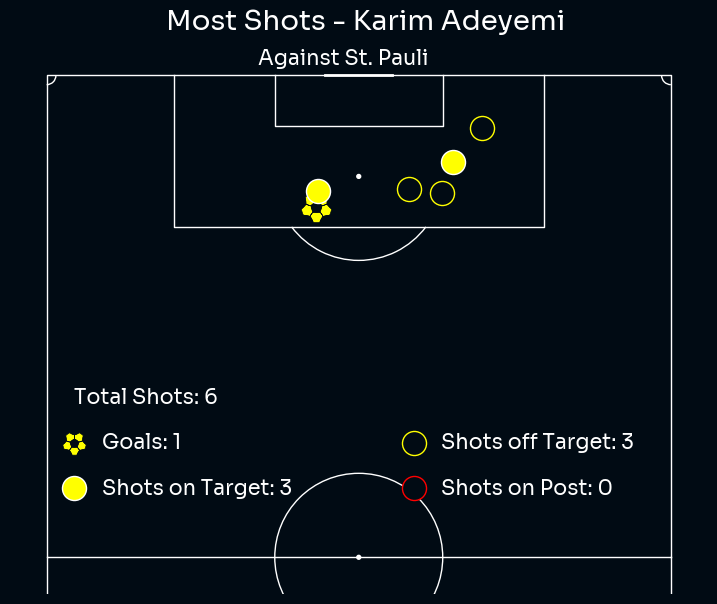

In [636]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
shotMap(ax,top_shots_df, top_shots_name,opposition_team,'yellow')

### Player with the most defensive Actions

In [261]:
df['type'].unique()

array(['Start', 'Pass', 'BallRecovery', 'MissedShots', 'BallTouch',
       'Interception', 'BlockedPass', 'Tackle', 'Dispossessed', 'Aerial',
       'TakeOn', 'Challenge', 'Clearance', 'CornerAwarded', 'Error',
       'SubstitutionOn', 'SubstitutionOff', 'Goal', 'KeeperPickup',
       'KeeperSweeper', 'Foul', 'Card', 'Save', 'SavedShot', 'Claim',
       'ShieldBallOpp', 'GoodSkill', 'FormationChange', 'OffsidePass',
       'OffsideProvoked', 'Punch', 'End', 'OffsideGiven', 'FormationSet',
       'Smother', 'ShotOnPost', 'PenaltyFaced', 'Carry'], dtype=object)

In [68]:
 # Filter only pass events
def_df = df[(df['type'] == 'BallRecovery') | (df['type'] == 'Interception') | (df['type'] == 'Tackle') | (df['type'] == 'Clearance') | (df['type'] == 'Aerial')]

# Count passes per player
def_counts = def_df.groupby('playerName')['index'].count().reset_index()

# Get the player with the most passes
most_def = def_counts.loc[def_counts['index'].idxmax()]

print(most_def)

# Get the player with the most passes
top_def_name = most_def['playerName']

print(top_def_name)

# Filter dataframe for passes made by that player
top_def_df = df[((df['type'] == 'BallRecovery') | (df['type'] == 'Interception') | (df['type'] == 'Tackle') | (df['type'] == 'Clearance') | (df['type'] == 'Aerial')) & (df['playerName'] == top_def_name)]

def_player_team = top_def_df['teamName'].iloc[0]

print(def_player_team)

# Get matchId of the player
matchId = df[df['teamName'] == def_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = df[df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
def_opposition_team = [team for team in teams_in_match if team != def_player_team][0]

print(def_opposition_team)

playerName    Moritz Jenz
index                  36
Name: 184, dtype: object
Moritz Jenz
Mainz 05
RB Leipzig


In [246]:
def player_defensive(ax,dfplayer,pname,against,teamcolor):
    pitch = Pitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    
    player_tk_s = dfplayer[(dfplayer['type']=='Tackle') & (dfplayer['outcomeType'] == 'Successful')]
    player_tk_u= dfplayer[(dfplayer['type']=='Tackle') & (dfplayer['outcomeType'] != 'Successful')]
    
    player_int_s = dfplayer[((dfplayer['type']=='Interception') | (dfplayer['type']=='BlockedPass')) & (dfplayer['outcomeType'] == 'Successful')]
    player_int_u = dfplayer[((dfplayer['type']=='Interception') | (dfplayer['type']=='BlockedPass')) & (dfplayer['outcomeType'] != 'Successful')]
    
    player_br_s = dfplayer[(dfplayer['type']=='BallRecovery') & (dfplayer['outcomeType'] == 'Successful')]
    player_br_u = dfplayer[(dfplayer['type']=='BallRecovery') & (dfplayer['outcomeType'] != 'Successful')]
    
    player_cl_s = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] == 'Successful')]
    player_cl_u = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] != 'Successful')]

    player_cl_s = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] == 'Successful')]
    player_cl_u = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] != 'Successful')]

    player_ar_s = dfplayer[(dfplayer['type']=='Aerial') & (dfplayer['qualifiers'].str.contains('Defensive')) & (dfplayer['outcomeType'] == 'Successful')]
    player_ar_u = dfplayer[(dfplayer['type']=='Aerial') & (dfplayer['qualifiers'].str.contains('Defensive')) & (dfplayer['outcomeType'] != 'Successful')]
    
    pitch.scatter(player_tk_s.x, player_tk_s.y, s=200, c=teamcolor, lw=1.5, edgecolor='white', marker='+', hatch='/////', ax=ax)
    pitch.scatter(player_tk_u.x, player_tk_u.y, s=100, c='grey', lw=1.5, edgecolor='white', marker='+',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_int_s.x, player_int_s.y, s=200, c='#fb694a', lw=1.5, edgecolor='white', marker='s', hatch='/////', ax=ax)
    pitch.scatter(player_int_u.x, player_int_u.y, s=100, c='grey', lw=1.5, edgecolor='white', marker='s',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_br_s.x, player_br_s.y, s=200, c='#fcbba1', lw=1.5, edgecolor='white', marker='o', hatch='/////', ax=ax)
    pitch.scatter(player_br_u.x, player_br_u.y, s=100, c='grey', lw=1.5, edgecolor='white', marker='o',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_cl_s.x, player_cl_s.y, s=200, c='yellow', lw=1.5, edgecolor='white', marker='d', hatch='/////', ax=ax)
    pitch.scatter(player_cl_u.x, player_cl_u.y, s=100, c='grey', lw=1.5, edgecolor='white', marker='d',alpha=0.5, hatch='/////', ax=ax)
    
    #pitch.scatter(player_fl_s.y, player_fl_s.x, s=250, c=teamcolor, lw=1.5, edgecolor=teamcolor, marker='x', hatch='/////', ax=ax)
    #pitch.scatter(player_fl_u.y, player_fl_u.x, s=150, c='grey', lw=1.5, edgecolor=teamcolor, marker='x',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_ar_s.x, player_ar_s.y, s=200, c='orange', lw=1.5, edgecolor='white', marker='^', hatch='/////', ax=ax)
    pitch.scatter(player_ar_u.x, player_ar_u.y, s=100, c='grey', lw=1.5, edgecolor='white', marker='^',alpha=0.5, hatch='/////', ax=ax)

    ax.text(10,80,f"Most Defensive Actions - {pname}", color='white', fontsize=22,fontproperties=font_prop)
    ax.text(35,73,f"Against {against}", color='white', fontsize=15,fontproperties=font_prop)

    player_tk_t = len(player_tk_s) + len(player_tk_u)
    player_int_t = len(player_int_s) + len(player_int_u)
    player_ar_t = len(player_ar_s) + len(player_ar_u)
    #<Passes into Penalty box: {len(pen_box)}> \n\n
    ax_text(-1, -10, f'''
    <Tackles: {len(player_tk_s)}/{player_tk_t}>     <Interceptions: {len(player_int_s)}/{player_int_t}>\n
    <Ball Recoveries: {len(player_br_s)}>     <Clearances: {len(player_cl_s)}>    <Aerials: {len(player_ar_s)}/{player_ar_t}>
    ''',
    color='white',fontproperties=font_prop,transform=ax.transAxes,
    highlight_textprops=[{'color':teamcolor}, {'color':'#fb694a'},{'color':'#fcbba1'},{'color':'yellow'},{'color':'orange'}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)
    
    return

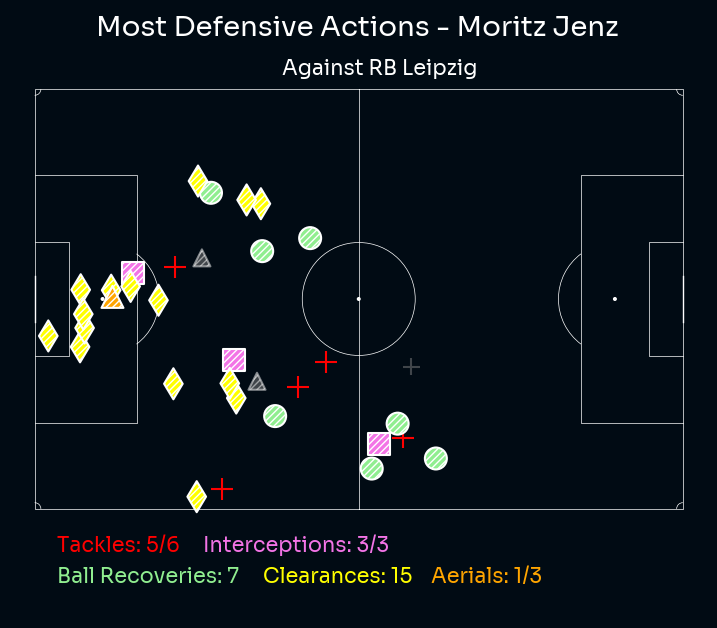

In [659]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
player_defensive(ax,top_def_df,top_def_name,opposition_team,'red')

### Player with the most touches

In [86]:
 # Filter only pass events
touch_df = df[df['touches'] == True]

# Count passes per player
touch_counts = touch_df.groupby('playerName')['index'].count().reset_index()

# Get the player with the most passes
most_touch = touch_counts.loc[touch_counts['index'].idxmax()]

print(most_touch)

# Get the player with the most passes
top_touch_name = most_touch['playerName']

print(top_touch_name)

# Filter dataframe for passes made by that player
top_touch_df = df[(df['touches'] == True) & (df['playerName'] == top_touch_name)]

touch_player_team = top_touch_df['teamName'].iloc[0]

print(touch_player_team)

# Get matchId of the player
matchId = df[df['teamName'] == touch_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = df[df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
touch_opposition_team = [team for team in teams_in_match if team != touch_player_team][0]

print(touch_opposition_team)

playerName    Emre Can
index              123
Name: 61, dtype: object
Emre Can
Borussia Dortmund
St. Pauli


In [213]:
def touchMap(ax,touches,pname,against,team1_facecolor):
    pitch = Pitch(pitch_type='uefa', half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    
    touches_final_third = touches[touches['x']>=70]
    touch_coords = touches[['x', 'y']].values

    # Calculate mean and standard deviation
    if len(touch_coords) > 0:
        mean_x = np.mean(touch_coords[:, 0])
        mean_y = np.mean(touch_coords[:, 1])
        std_x = np.std(touch_coords[:, 0])
        std_y = np.std(touch_coords[:, 1])

        # Create boundaries for territory
        x_min = mean_x - std_x
        x_max = mean_x + std_x
        y_min = mean_y - std_y
        y_max = mean_y + std_y

        # Filter the points within one standard deviation
        valid_coords = touch_coords[
            (touch_coords[:, 0] >= x_min) & (touch_coords[:, 0] <= x_max) &
            (touch_coords[:, 1] >= y_min) & (touch_coords[:, 1] <= y_max)
        ]

        # Create a convex hull for the filtered points
        if len(valid_coords) > 2:  # Convex hull requires at least 3 points
            hull = ConvexHull(valid_coords)
            hull_points = valid_coords[hull.vertices]

            # Fill the territory with a grey color
            ax.fill(hull_points[:, 0], hull_points[:, 1], color='grey', alpha=0.3)

    # Scatter plot for touches
    ax.scatter(touches.x, touches.y, marker='o', ec=team1_facecolor, s=100, color=background)
    ax.scatter(mean_x, mean_y, marker='o', ec=team1_facecolor, s=1000, color='white', zorder=3)
    ax.text(mean_x - 2.5, mean_y-1, pname[:2], color=background, fontproperties=font_prop, fontsize=15)

    ax.text(15,80,f"Most Touches - {pname}", color='white', fontsize=25,fontproperties=font_prop)
    ax.text(35,73,f"Against {against}", color='white', fontsize=20,fontproperties=font_prop)
    
    ax_text(-1, -7, f'''
    Touches: {len(touches)}                                         <Final Third: {len(touches_final_third)}>
    ''',
    color='white',fontproperties=font_prop,transform=ax.transAxes,
    highlight_textprops=[{'color':team1_facecolor}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)

    return

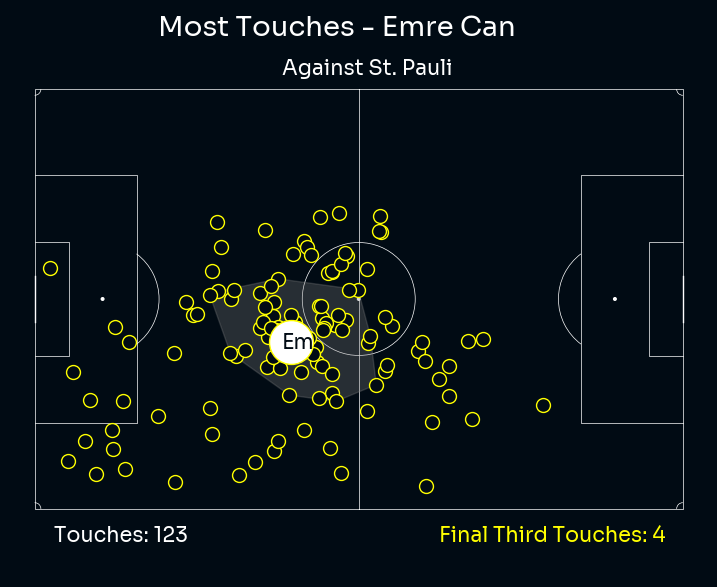

In [663]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
touchMap(ax,top_touch_df,top_touch_name,opposition_team,'yellow')

### Player with the most Passes Received

In [104]:
def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index","matchId", "x", "y", "endX", "endY", "teamName", "playerId", "receiver","qualifiers", "type","playerName", "outcomeType"]]

    return df_passes

In [105]:
df_passes = get_passes_df(df)

In [106]:
 # Filter only pass events
rec_df = df_passes.copy()

# Count passes per player
rec_counts = rec_df.groupby('receiver')['index'].count().reset_index()

# Get the player with the most passes
most_rec = rec_counts.loc[rec_counts['index'].idxmax()]

print(most_rec)

rec_playerName = rec_df[rec_df['receiver'] == most_rec['receiver']].playerName.unique().tolist()[0]
# Get the player with the most passes
#top_rec_name = most_rec['playerName']

print(rec_playerName)

# Filter dataframe for passes made by that player
top_rec_df = rec_df[rec_df['receiver'] == most_rec['receiver']]

rec_player_team = top_rec_df['teamName'].iloc[0]

print(rec_player_team)

# Get matchId of the player
matchId = rec_df[rec_df['teamName'] == rec_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = rec_df[rec_df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
rec_opposition_team = [team for team in teams_in_match if team != rec_player_team][0]

print(rec_opposition_team)


receiver    111212.0
index           96.0
Name: 33, dtype: float64
Marcel Sabitzer
Borussia Dortmund
St. Pauli


In [219]:
def passes_recieved(ax,filtered_rows,pname,against,team_color):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5,
                         positional=True, shade_middle=True, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)
    #plt.gca().invert_xaxis()

    
    keypass_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('KeyPass')]
    assist_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('IntentionalGoalAssist')]
    pr = len(filtered_rows)
    kpr = len(keypass_recieved_df)
    asr = len(assist_recieved_df)

    lc1 = pitch.lines(filtered_rows.x, filtered_rows.y, filtered_rows.endX, filtered_rows.endY, lw=1, transparent=True, comet=False,color='grey', ax=ax, alpha=0.5)
    lc2 = pitch.lines(keypass_recieved_df.x, keypass_recieved_df.y, keypass_recieved_df.endX, keypass_recieved_df.endY, lw=8, transparent=True, comet=True,color=team_color, ax=ax, alpha=0.8)
    lc3 = pitch.lines(assist_recieved_df.x, assist_recieved_df.y, assist_recieved_df.endX, assist_recieved_df.endY, lw=6, transparent=True, comet=True,color=team_color, ax=ax, alpha=0.9)
    
    sc1 = pitch.scatter(filtered_rows.endX, filtered_rows.endY, s=50, edgecolors='white', linewidths=1, c=background, zorder=2,alpha=0.5, ax=ax)
    sc2 = pitch.scatter(keypass_recieved_df.endX, keypass_recieved_df.endY, s=50, edgecolors='white', linewidths=1, c=background, zorder=2, ax=ax)
    sc3 = pitch.scatter(assist_recieved_df.endX, assist_recieved_df.endY, s=100, edgecolors='white', linewidths=1.5, marker='o', c=team_color, zorder=2, ax=ax)

    ax.text(2,80,f"Most Passes Received - {pname}", color='white', fontsize=22,fontproperties=font_prop)
    ax.text(35,73,f"Against {against}", color='white', fontsize=18,fontproperties=font_prop)
    ax_text(-3,-6, f'''
    <Passes Recieved:{pr+kpr}>             <Keypasses Recieved:{kpr}>
    ''', color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':'white'}, {'color':team_color}], fontsize=18, ha='left', va='center', ax=ax)

    return

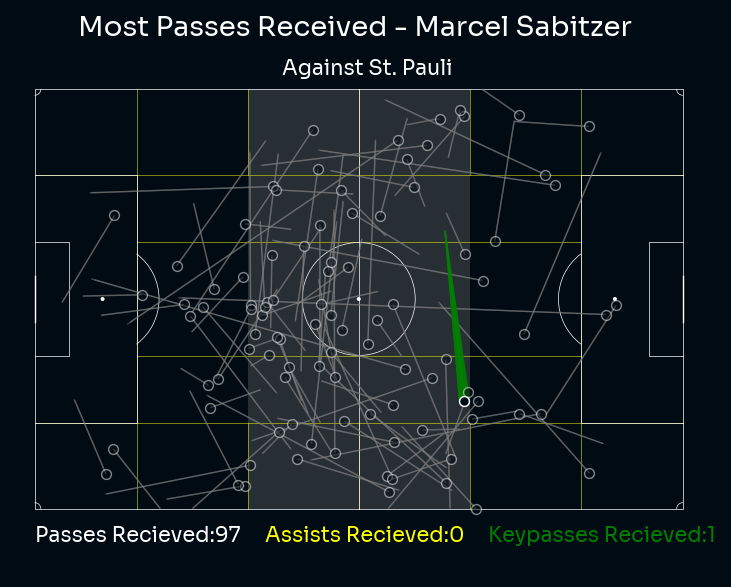

In [668]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
passes_recieved(ax,top_rec_df,rec_playerName,opposition_team,'yellow')

### Player with most Dribbles

In [119]:
# Filter only TakeOn events
dribble_df = df[df['type'] == 'TakeOn']

# Drop rows where playerName is NaN
dribble_df = dribble_df.dropna(subset=['playerName'])

# Filter for successful dribbles
successful_dribble_df = dribble_df[dribble_df['outcomeType'] == 'Successful']

# Count successful dribbles per player
successful_dribble_counts = successful_dribble_df.groupby('playerName')['index'].count().reset_index()

# Get the player with the most successful dribbles
most_dribble = successful_dribble_counts.loc[successful_dribble_counts['index'].idxmax()]


print(most_dribble)

# Get the player with the most passes
top_dribble_name = most_dribble['playerName']

print(top_dribble_name)

# Filter dataframe for passes made by that player
top_dribble_df = df[(df['type'] == 'TakeOn') & (df['playerName'] == top_dribble_name)]

dribble_player_team = top_dribble_df['teamName'].iloc[0]

print(dribble_player_team)

# Get matchId of the player
matchId = df[df['teamName'] == dribble_player_team]['matchId'].iloc[0]

# Get the two unique team names for that match
teams_in_match = df[df['matchId'] == matchId]['teamName'].unique()

# Get the opposing team (the one that is NOT player_team)
dribble_opposition_team = [team for team in teams_in_match if team != dribble_player_team][0]

print(dribble_opposition_team)

playerName    Jamal Musiala
index                     4
Name: 30, dtype: object
Jamal Musiala
Bayern Munich
VfB Stuttgart


In [223]:
def individual_dribble(ax,df_dribble,pname,against,team_color):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)

    led_shot1 = df_dribble[(df_dribble['type']=='TakeOn') & (df_dribble['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df_dribble[(df_dribble['type']=='TakeOn') & (df_dribble['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df_dribble[(df_dribble['type']=='TakeOn') & (df_dribble['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist'))]
    led_goal2 = df_dribble[(df_dribble['type']=='TakeOn') & (df_dribble['type'].shift(-1)=='Goal')]
    led_goal3 = df_dribble[(df_dribble['type']=='TakeOn') & (df_dribble['type'].shift(-3)=='Goal')]
    led_goal12 = pd.concat([led_goal1, led_goal2])
    led_goal = pd.concat([led_goal12, led_goal3])
    
    df_to = df_dribble[(df_dribble['type']=='TakeOn')]
    t_ons = df_to[df_to['outcomeType']=='Successful']
    t_onu = df_to[df_to['outcomeType']=='Unsuccessful']
    df_xT_inc = df_dribble[df_dribble['xT']>0]
    df_xT_dec = df_dribble[df_dribble['xT']<0]
    xT_by_Carry = df_dribble['xT'].sum().round(2)
    #df_dribble = df_dribble.copy()
    df_dribble.loc[:, 'Length'] = np.sqrt((df_dribble['x'] - df_dribble['endX'])**2 + (df_dribble['y'] - df_dribble['endY'])**2)
    median_length = round(df_dribble['Length'].median(),2)
    total_length = round(df_dribble['Length'].sum(),2)
    if len(df_to)!=0:
        success_rate = round((len(t_ons)/len(df_to))*100, 2)
    else:
        success_rate = 0

    ax.scatter(t_ons.x, t_ons.y, s=250, color=team_color, edgecolor='white', lw=2, zorder=5)
    ax.scatter(t_onu.x, t_onu.y, s=250, color='None', edgecolor='grey', hatch='/////', lw=1,alpha=0.5, zorder=5)

    ax.text(5,80,f"Most Dribbles - {pname}", color='white', fontsize=25,fontproperties=font_prop)
    ax.text(30,73,f"Against {against}", color='white', fontsize=20,fontproperties=font_prop)

    ax_text(-3, -5, f'''
    <Successful TakeOns: {len(t_ons)}/{len(df_to)}>  
''', highlight_textprops=[{'color':team_color}],color='white', fontsize=18, ha='left', 
            va='top',fontproperties=font_prop, ax=ax)
    return

C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


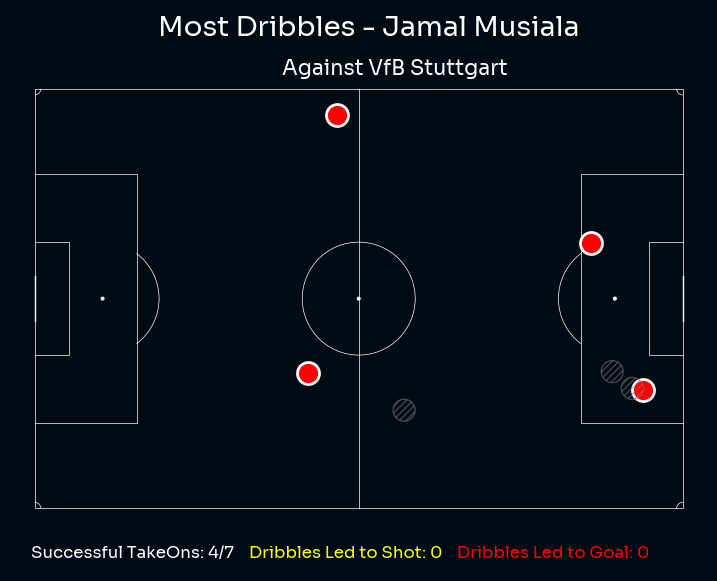

In [676]:
fig,ax=plt.subplots(figsize=(9,9),facecolor=background)
individual_dribble(ax,top_dribble_df,top_dribble_name,opposition_team,'red')

### Top 5 GoalKeepers

In [472]:
df['type'].unique()

array(['Start', 'Pass', 'BallRecovery', 'MissedShots', 'BallTouch',
       'Interception', 'BlockedPass', 'Tackle', 'Dispossessed', 'Aerial',
       'TakeOn', 'Challenge', 'Clearance', 'CornerAwarded', 'Error',
       'SubstitutionOn', 'SubstitutionOff', 'Goal', 'KeeperPickup',
       'KeeperSweeper', 'Foul', 'Card', 'Save', 'SavedShot', 'Claim',
       'ShieldBallOpp', 'GoodSkill', 'FormationChange', 'OffsidePass',
       'OffsideProvoked', 'Punch', 'End', 'OffsideGiven', 'FormationSet',
       'Smother', 'ShotOnPost', 'PenaltyFaced', 'Carry'], dtype=object)

In [156]:
def top5_goalkeepers(ax,df,cmap):
    # Filter goalkeeper-related events
    gk_df = df[df['type'].isin(['KeeperSweeper', 'Save', 'Claim', 'Punch', 'Smother'])]
    
    # Count occurrences of each action per player
    gk_action_counts = gk_df.groupby(['shortName', 'type']).size().unstack(fill_value=0)
    
    # Get the top 5 players based on total actions
    top_5_players = gk_df['shortName'].value_counts().head(5).index
    
    # Filter only top 5 players
    top_5_gk_actions = gk_action_counts.loc[top_5_players]
    
    # Reset index for better readability
    top_5_gk_actions = top_5_gk_actions.reset_index()
    
    
    # Set player names as index for plotting
    top_5_gk_actions.set_index("shortName", inplace=True)
    
    
    
    # Plot horizontal stacked bar chart
    top_5_gk_actions.plot(kind="barh", stacked=True, colormap=cmap, ax=ax)
    
    # Add counts inside the bars
    for i, player in enumerate(top_5_gk_actions.index):
        total_width = 0  # Keep track of stacked width
        for action in top_5_gk_actions.columns:
            value = top_5_gk_actions.loc[player, action]
            if value > 0:  # Only annotate nonzero values
                ax.text(total_width + value / 2, i, str(int(value)), 
                        ha='center', va='center', fontsize=15, color='white',fontproperties=font_prop)
            total_width += value
    


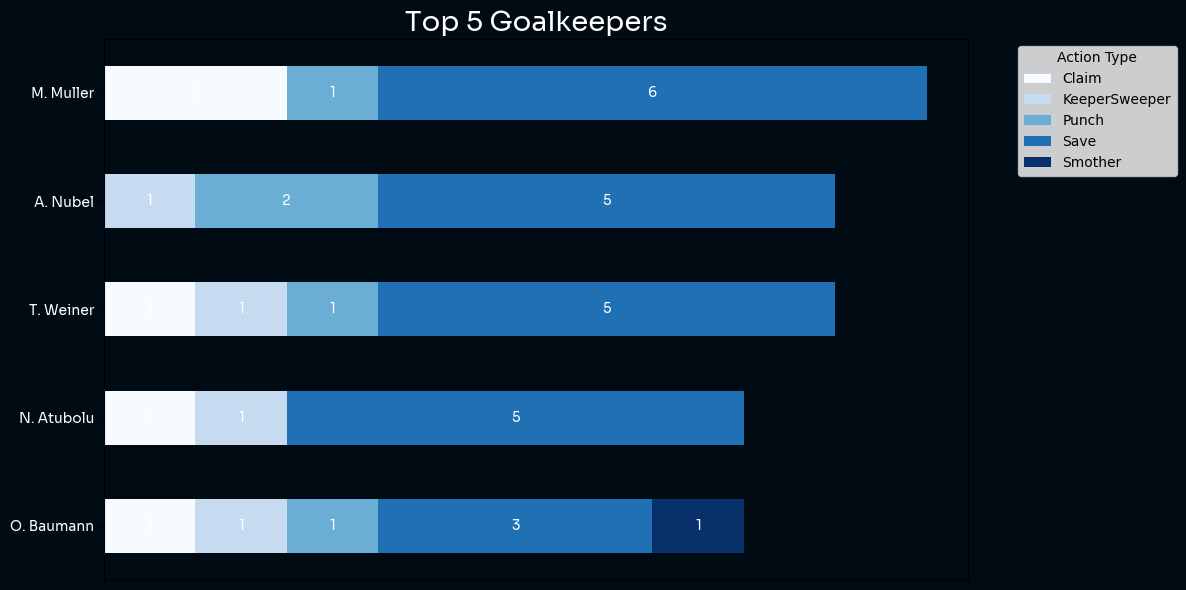

In [141]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

fig.set_facecolor(background)
ax.set_facecolor(background)

top5_goalkeepers(ax,df,"Blues")

plt.title("Top 5 Goalkeepers",color='white',fontproperties=font_prop,fontsize=20)
    
plt.ylabel("")  # Hide y-axis label
plt.xticks([])  # Hide x-axis ticks
plt.yticks(fontsize=10, color="white", fontproperties=font_prop)

# Add legend
plt.legend(title="Action Type", bbox_to_anchor=(1.05, 1),loc="upper left")

# Adjust layout and invert y-axis order
plt.gca().invert_yaxis()  
plt.tight_layout()

### Top 5 Threat Creators

In [160]:
xt_distribution = df[df['type'].isin(['Pass', 'Carry'])] \
        .groupby(['shortName', 'type'])['xT'].sum() \
        .unstack(fill_value=0)
    
xt_top5 = xt_distribution.sum(axis=1).nlargest(5).index
xt_top5_df = xt_distribution.loc[xt_top5].sort_values(by=['Pass', 'Carry'], ascending=False)

xt_top5_df['Carry'] = round(xt_top5_df['Carry'],2)
xt_top5_df['Pass'] = round(xt_top5_df['Pass'],2)

In [161]:
xt_top5

Index(['J. Juranovic', 'D. Giannoulis', 'M. Weiser', 'M. Olise',
       'N. Weisshaupt'],
      dtype='object', name='shortName')

In [167]:
def top_5_xT(ax,df,cmap):

    xt_distribution = df[df['type'].isin(['Pass', 'Carry'])] \
        .groupby(['shortName', 'type'])['xT'].sum() \
        .unstack(fill_value=0)
    
    xt_top5 = xt_distribution.sum(axis=1).nlargest(5).index

    xt_top5_df = xt_distribution.loc[xt_top5].sort_values(by=['Pass', 'Carry'], ascending=(False,False))
    #xt_top5_df = xt_distribution.loc[xt_top5].sort_values(by=xt_distribution.loc[xt_top5].sum(axis=1), ascending=False)

    
    xt_top5_df['Carry'] = round(xt_top5_df['Carry'],2)
    xt_top5_df['Pass'] = round(xt_top5_df['Pass'],2)

    # Create Total column
    xt_top5_df["Total"] = xt_top5_df["Pass"] + xt_top5_df["Carry"]
    
    # Sort by Total in descending order
    xt_top5_df = xt_top5_df.sort_values(by="Total", ascending=False)

    xt_top5_df = xt_top5_df.drop(columns=["Total"])

    # Set player names as index for plotting
    #xt_top5_df.set_index("playerName", inplace=True)
    
    
    
    # Plot horizontal stacked bar chart
    xt_top5_df.plot(kind="barh", stacked=True, colormap=cmap, ax=ax)
    
    # Add counts inside the bars
    for i, player in enumerate(xt_top5_df.index):
        total_width = 0  # Keep track of stacked width
        for action in xt_top5_df.columns:
            value = xt_top5_df.loc[player, action]
            if value > 0.1:  # Only annotate nonzero values
                ax.text(total_width + value / 2, i, value, 
                        ha='center', va='center', fontsize=15, color='white',fontproperties=font_prop)
            total_width += value

    return ax

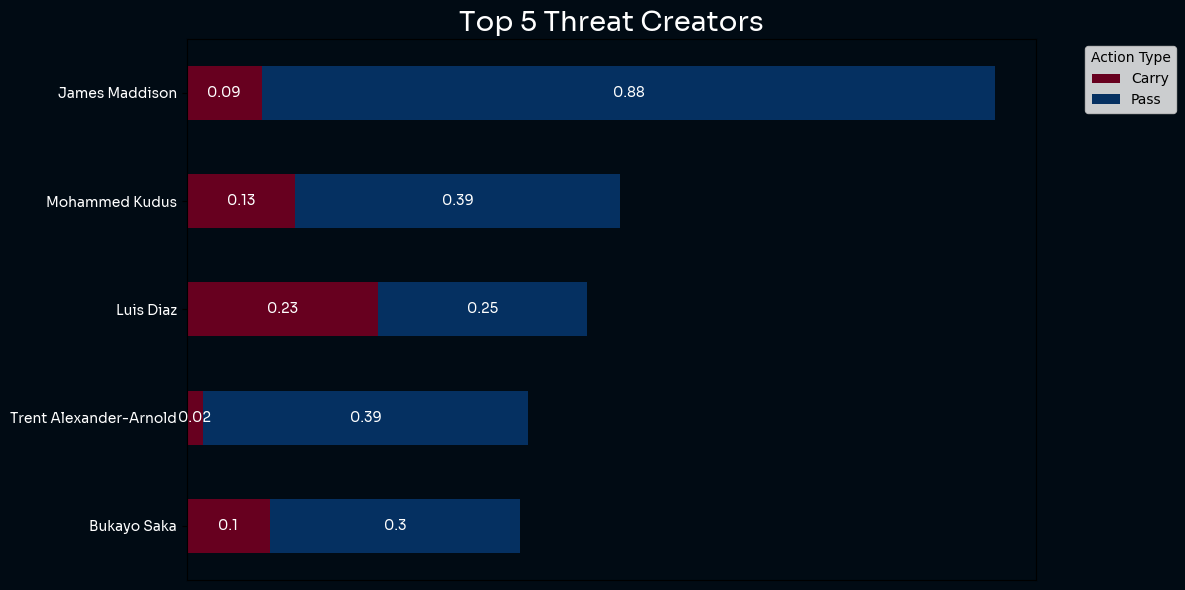

In [606]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

fig.set_facecolor(background)
ax.set_facecolor(background)

top_5_xT(ax,df,"RdBu")

plt.title("Top 5 Threat Creators",color='white',fontproperties=font_prop,fontsize=20)
    
plt.ylabel("")  # Hide y-axis label
plt.xticks([])  # Hide x-axis ticks
plt.yticks(fontsize=10, color="white", fontproperties=font_prop)

# Add legend
plt.legend(title="Action Type", bbox_to_anchor=(1.05, 1),loc="upper left")

# Adjust layout and invert y-axis order
plt.gca().invert_yaxis()  
plt.tight_layout()

### Top 5 Ball Carriers

In [607]:
df['type'].unique()

array(['Start', 'Pass', 'BallRecovery', 'MissedShots', 'BallTouch',
       'Interception', 'BlockedPass', 'Tackle', 'Dispossessed', 'Aerial',
       'TakeOn', 'Challenge', 'Clearance', 'CornerAwarded', 'Error',
       'SubstitutionOn', 'SubstitutionOff', 'Goal', 'KeeperPickup',
       'KeeperSweeper', 'Foul', 'Card', 'Save', 'SavedShot', 'Claim',
       'ShieldBallOpp', 'GoodSkill', 'FormationChange', 'OffsidePass',
       'OffsideProvoked', 'Punch', 'End', 'OffsideGiven', 'FormationSet',
       'Smother', 'ShotOnPost', 'PenaltyFaced', 'Carry'], dtype=object)

In [187]:
def top_5_carries(ax, df, cmap):
    carry_df = df[df['type'] == 'Carry']

    # Drop rows where playerName or outcomeType is NaN
    carry_df = carry_df.dropna(subset=['shortName', 'outcomeType'])
    
    # Filter for successful carries
    successful_carry_df = carry_df[carry_df['outcomeType'] == 'Successful']
    
    # Count successful carries per player
    successful_carry_counts = successful_carry_df.groupby('shortName')['index'].count().reset_index()
    
    # Rename columns for clarity
    successful_carry_counts.columns = ['shortName', 'successfulCarries']
    
    # Get the top 5 players with the most successful carries
    top_5_carry = successful_carry_counts.nlargest(5, 'successfulCarries').reset_index(drop=True)

    #top_5_carry.plot(kind="barh", stacked=False, colormap=cmap, ax=ax)
    # Plot horizontal bar chart
    bars = ax.barh(top_5_carry['shortName'], top_5_carry['successfulCarries'],  color=cmap,height=0.5)

    # Add counts inside the bars
    for bar, value in zip(bars, top_5_carry['successfulCarries']):
        ax.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
                str(value), ha='center', va='center', fontsize=18, color='white', fontproperties=font_prop)

    return ax


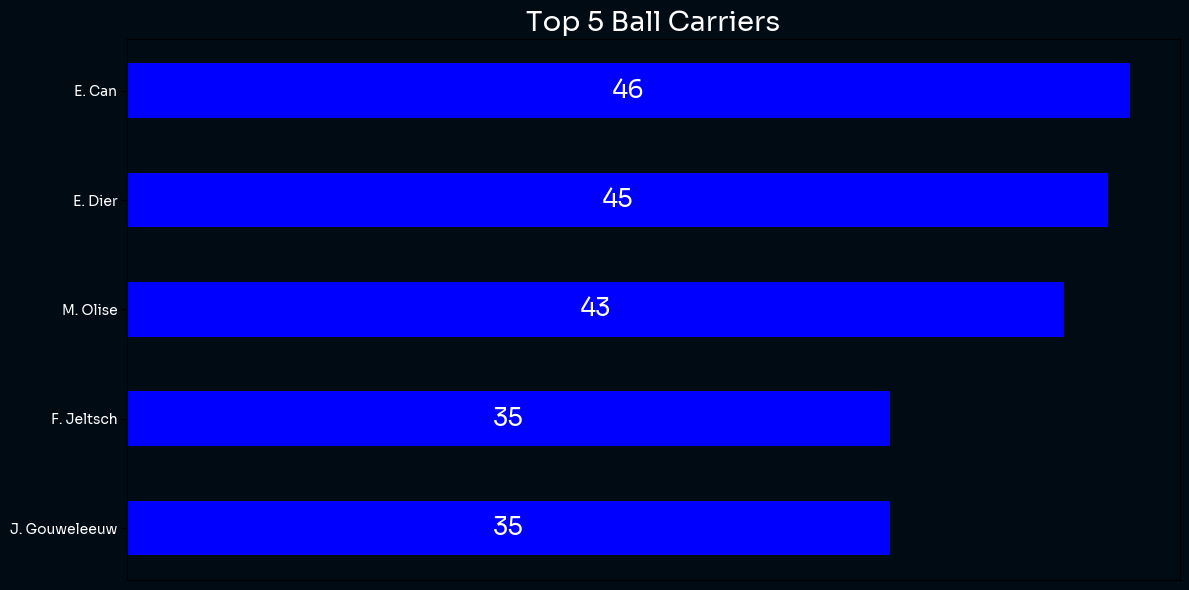

In [188]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

fig.set_facecolor(background)
ax.set_facecolor(background)

top_5_carries(ax,df,"Blue")

plt.title("Top 5 Ball Carriers",color='white',fontproperties=font_prop,fontsize=20)
    
plt.ylabel("")  # Hide y-axis label
plt.xticks([])  # Hide x-axis ticks
plt.yticks(fontsize=15, color="white", fontproperties=font_prop)

# Adjust layout and invert y-axis order
plt.gca().invert_yaxis()  
plt.tight_layout()

## Player Dashboard

C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


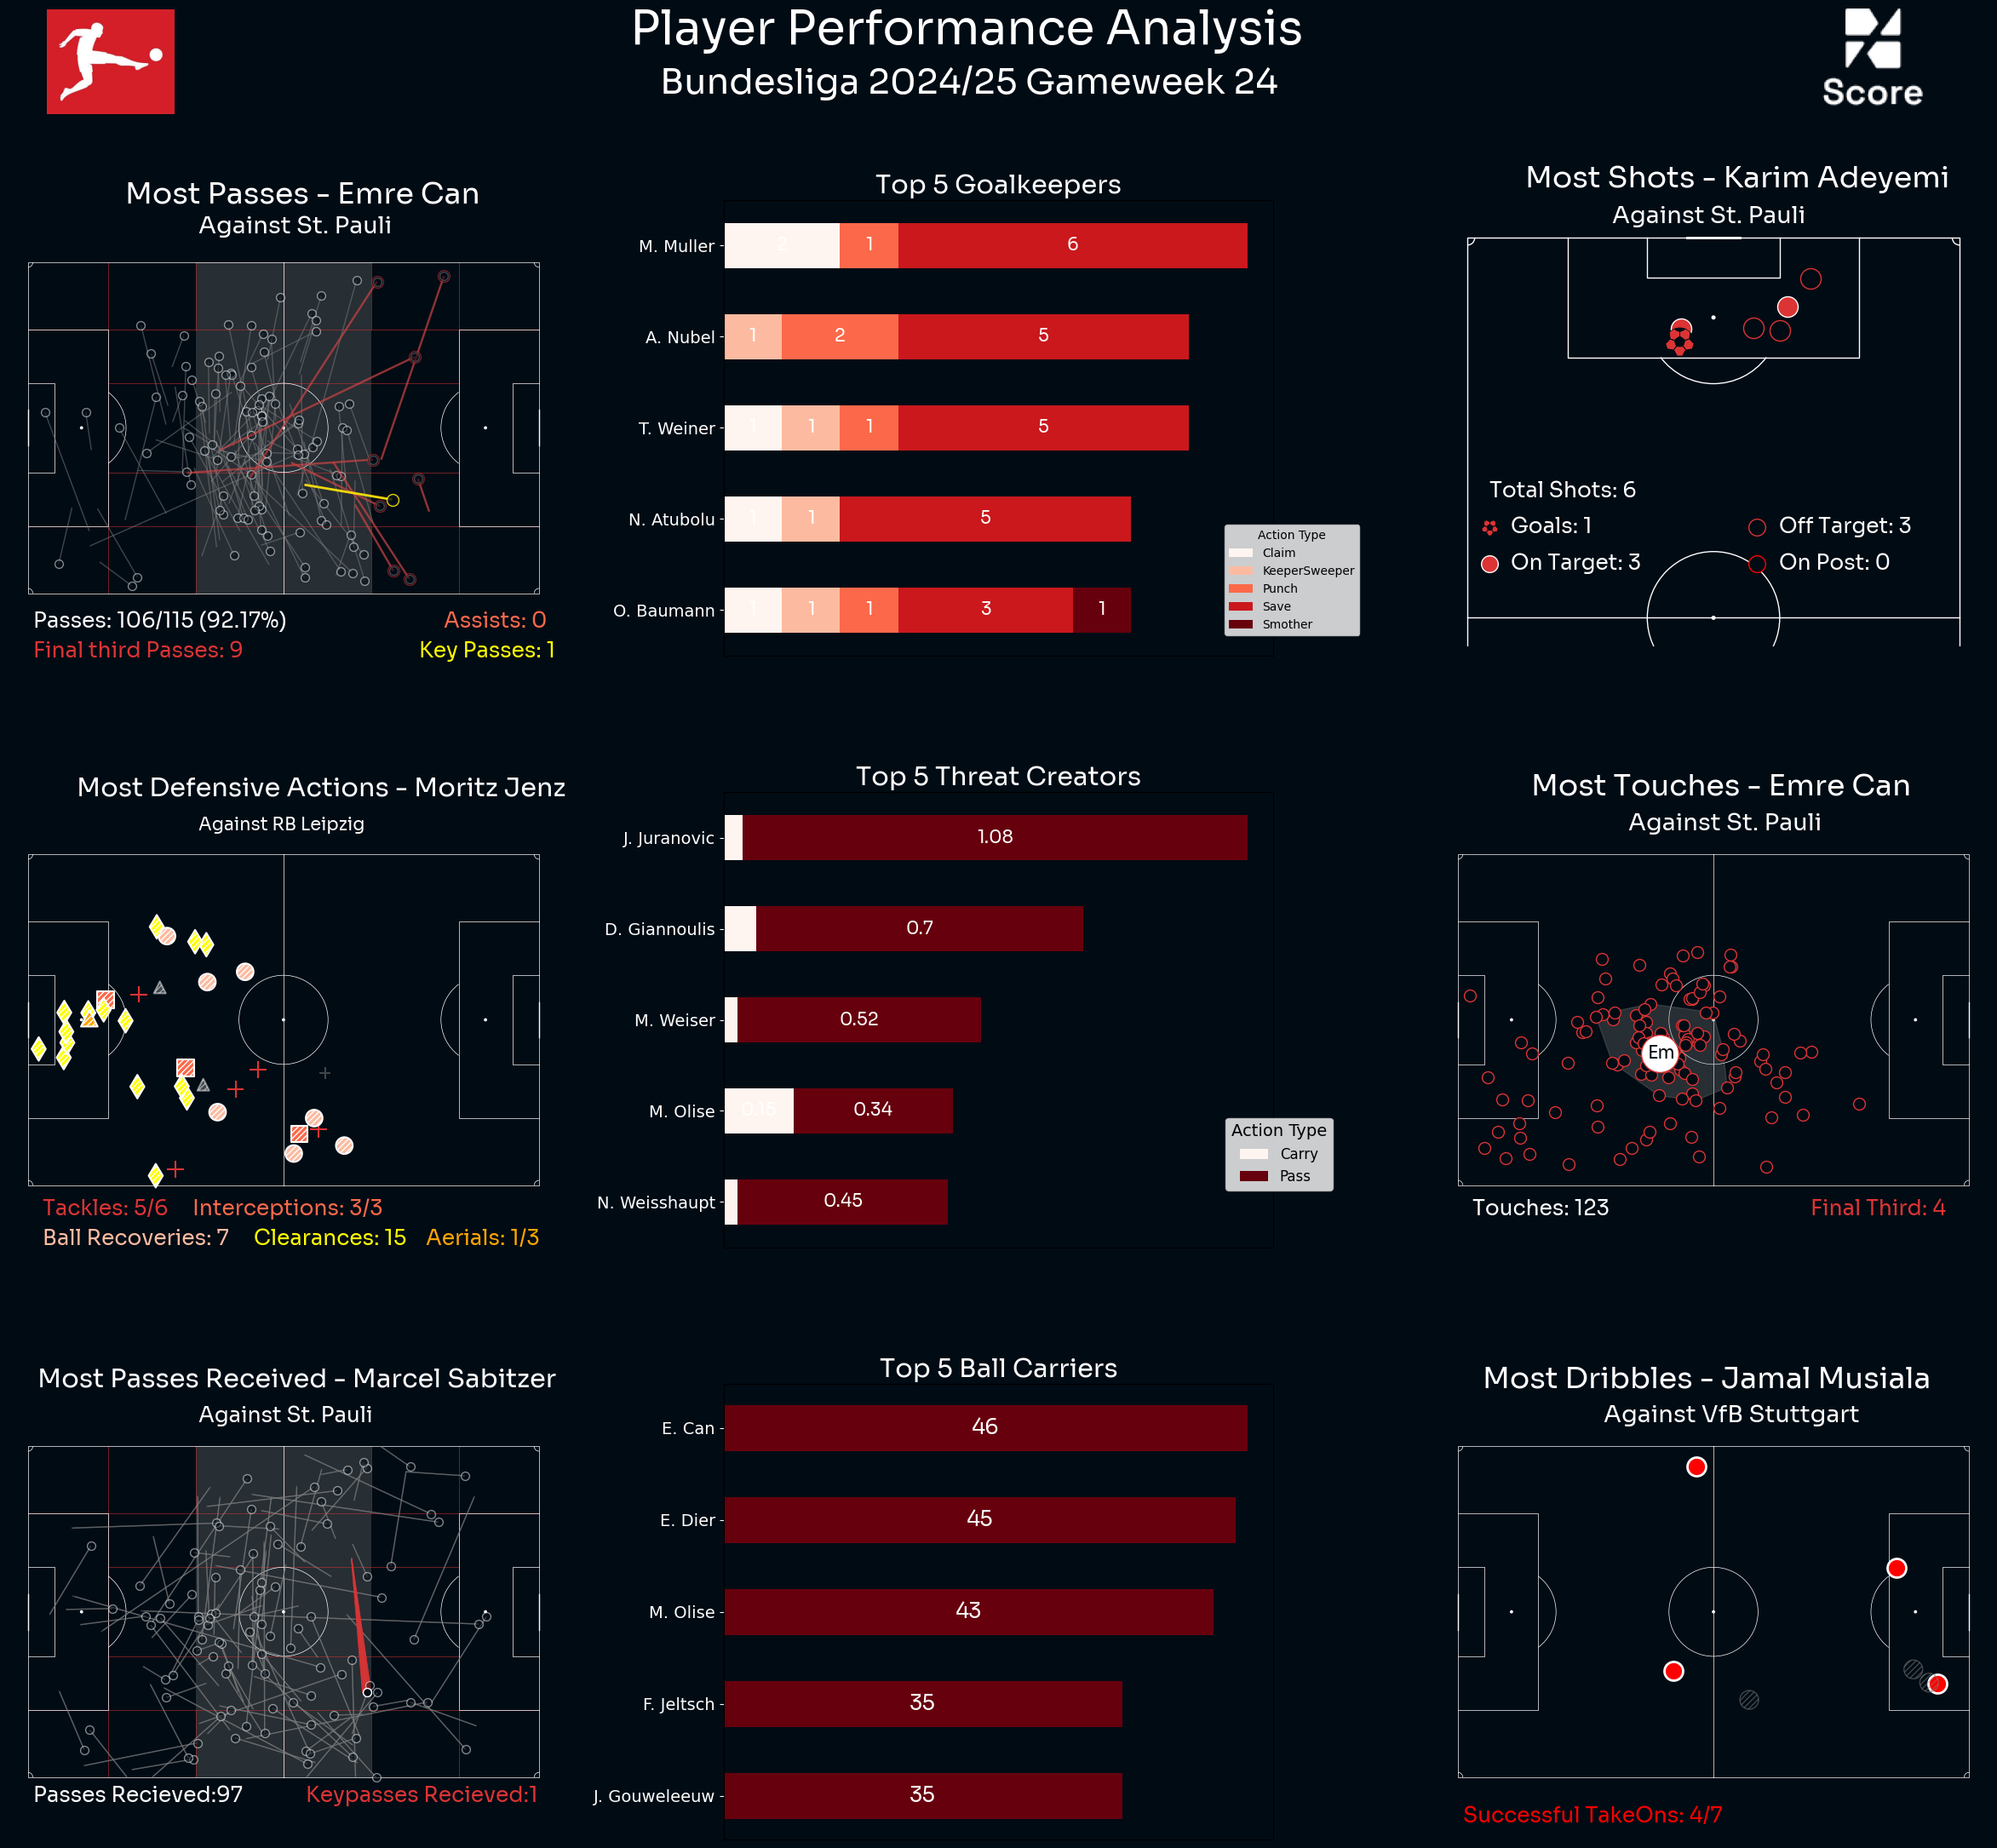

In [249]:
fig, axes = plt.subplots(3, 3, figsize=(30, 25), facecolor=background)
league = 'Bundesliga 2024/25 Gameweek 24'


logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')
league_logo = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/Bundesliga.jpg')
ax_image = add_image(
    league_logo, fig, left=0.14, bottom=0.92, width=0.05, height=0.05,aspect='equal'
)
ax_image = add_image(
    logo, fig, left=0.83, bottom=0.92, width=0.05, height=0.05,aspect='equal'
)


fig.suptitle(f'Player Performance Analysis', fontsize=40,fontproperties=font_prop, color='white', y=0.97)
fig.text(0.38,0.93,f'{league}',fontsize=30,fontproperties=font_prop, color='white')

team_color = '#dc3434'

player_passMap2(axes[0,0],top_passer_df, top_passer_name,passer_player_team,passer_opposition_team,team_color)

shotMap(axes[0,2],top_shots_df,top_shots_name,shots_opposition_team,team_color)

player_defensive(axes[1,0],top_def_df,top_def_name,def_opposition_team,team_color)

touchMap(axes[1,2],top_touch_df,top_touch_name,touch_opposition_team,team_color)

passes_recieved(axes[2,0],top_rec_df,rec_playerName,rec_opposition_team,team_color)

individual_dribble(axes[2,2],top_dribble_df,top_dribble_name,dribble_opposition_team,'red')

top5_goalkeepers(axes[0,1],df,"Reds")
axes[0,1].set_facecolor(background)
axes[0,1].set_title("Top 5 Goalkeepers", color='white', fontproperties=font_prop, fontsize=22)
axes[0,1].set_ylabel("")
axes[0,1].set_xticks([])
axes[0,1].tick_params(axis="y", labelsize=14, colors="white")
axes[0,1].legend(title="Action Type", bbox_to_anchor=(0.9, 0.3), loc="upper left")
axes[0,1].invert_yaxis()


top_5_xT(axes[1,1],df,"Reds")
axes[1,1].set_facecolor(background)
axes[1,1].set_title("Top 5 Threat Creators",color='white',fontproperties=font_prop,fontsize=22)
    
axes[1,1].set_ylabel("")  # Hide y-axis label
axes[1,1].set_xticks([])  # Hide x-axis ticks
axes[1,1].tick_params(axis="y", labelsize=14, colors="white")

# Add legend
axes[1,1].legend(title="Action Type", bbox_to_anchor=(0.9, 0.3),loc="upper left",fontsize=12,title_fontsize=14)

# Adjust layout and invert y-axis order
axes[1,1].invert_yaxis() 

top_5_carries(axes[2,1],df,'#67000d')
axes[2,1].set_facecolor(background)
axes[2,1].set_title("Top 5 Ball Carriers",color='white',fontproperties=font_prop,fontsize=22)
    
axes[2,1].set_ylabel("")  # Hide y-axis label
axes[2,1].set_xticks([])  # Hide x-axis ticks
axes[2,1].tick_params(axis="y", labelsize=14, colors="white")

# Adjust layout and invert y-axis order
axes[2,1].invert_yaxis()  

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3)

fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/Dashboards/Bundesliga24.png',dpi=500,bbox_inches = 'tight',facecolor=background)